In [745]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn import metrics
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LassoCV
from sklearn.model_selection import GridSearchCV
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from pytorch_ops import soft_rank, soft_sort
from tqdm import tqdm
sns.set()
import warnings
warnings.filterwarnings("ignore")


In [746]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.cross_decomposition import CCA
from sklearn.cross_decomposition import PLSCanonical
from sklearn.cross_decomposition import PLSSVD
from torch.utils.data import random_split
def softmax(x):
    return(np.exp(x)/np.exp(x).sum())

def my_custom_loss_func_exp(y_true, y_pred):
    return spearmanr(np.exp(y_true), np.exp(y_pred)).correlation  

def my_custom_loss_func(y_true, y_pred):
    #y_pred = np.exp(np.array(y_pred))
    return spearmanr(y_true, y_pred).correlation

def evaluate_model_mean(X, y, model, test_size=0.33, loss = my_custom_loss_func, state = 100):
    
    score = []
    for i in range(state):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,random_state=i)
        X_train = np.array(X_train)
        X_test = np.array(X_test)
       
        model.fit(X_train,y_train)
        train_score = loss(y_train, model.predict(X_train))
        y_predict = model.predict(X_test)
        test_score = loss(y_test , y_predict.reshape(-1))
        score.append(test_score)
        
    return np.mean(np.array(score))


In [747]:
path = 'data/'
X_train = pd.read_csv( path + 'X_train.csv')
Y_train = pd.read_csv(path + 'Y_train.csv')
X_test = pd.read_csv(path + 'X_test.csv')

- ID: Unique row identifier, associated with a day (DAY_ID) and a country (COUNTRY),
- DAY_ID: Day identifier - dates have been anonymized, but all data corresponding to a specific day is consistent,
- COUNTRY: Country identifier - DE = Germany, FR = France, 

and then contains daily commodity price variations:

- GAS_RET: European gas,
- COAL_RET: European coal,
- CARBON_RET: Carbon emissions futures,

weather measures (daily, in the country x):

- x_TEMP: Temperature,
- x_RAIN: Rainfall,
- x_WIND: Wind,

energy production measures (daily, in the country x),

- x_GAS: Natural gas,
- x_COAL: Hard coal,
- x_HYDRO: Hydro reservoir,
- x_NUCLEAR: Daily nuclear production,
- x_SOLAR: Photovoltaic,
- x_WINDPOW: Wind power,
- x_LIGNITE: Lignite,

and electricity use metrics (daily, in the country x),

- x_CONSUMPTON: Total electricity consumption,
- x_RESIDUAL_LOAD: Electricity consumption after using all renewable energies,
- x_NET_IMPORT: Imported electricity from Europe,
- x_NET_EXPORT: Exported electricity to Europe,
- DE_FR_EXCHANGE: Total daily electricity exchange between Germany and France,
- FR_DE_EXCHANGE: Total daily electricity exchange between France and Germany.

Output data sets are composed of two columns:

- ID: Unique row identifier - corresponding to the input identifiers,
- TARGET: Daily price variation for futures of 24H electricity baseload.

In [748]:
data = pd.merge(X_train, Y_train, on=['ID'])
all_data = data.copy()
all_data['train'] = 1
all_data = pd.concat([all_data,X_test])
all_data['TARGET'] = all_data['TARGET'].fillna(0)
all_data['train'] = all_data['train'].fillna(0)

In [749]:
from sklearn.impute import KNNImputer

def regress_var(df, x_columns, y_column, model, out = True):
    temp = df.dropna().copy()
    X = np.array(temp[x_columns])
    y = np.array(temp[y_column])
    model.fit(X,y)
    if(out):
        print("Model score", model.score(X,y))
    return df.apply(lambda row: model.predict(np.array(row[x_columns]).reshape(-1,len(x_columns)))[0] if(np.isnan(row[y_column])) else row[y_column], axis=1)


def clean_knn(all_data_clean):
    imputer = KNNImputer(n_neighbors=2)
    remove_columns = ['ID','DAY_ID','TARGET','train']
    keep = all_data_clean.columns.difference(remove_columns)
    all_data_clean[keep] = imputer.fit_transform(all_data_clean[keep])
    return all_data_clean
    
def clean_regression(all_data_clean):
    
    #all_data_clean['DE_FR_EXCHANGE'] = all_data_clean['DE_FR_EXCHANGE'].fillna(0)
    #all_data_clean['FR_DE_EXCHANGE'] = all_data_clean['FR_DE_EXCHANGE'].fillna(0)
    
    all_data_clean['DE_FR_EXCHANGE'] = all_data_clean['DE_FR_EXCHANGE'].fillna(all_data_clean['DE_FR_EXCHANGE'].mean(numeric_only=True))
    all_data_clean['FR_DE_EXCHANGE'] = all_data_clean['FR_DE_EXCHANGE'].fillna(all_data_clean['FR_DE_EXCHANGE'].mean(numeric_only=True))
    
    x_columns = ['DE_FR_EXCHANGE']
    y_column = 'DE_NET_EXPORT'
    all_data_clean[y_column] = regress_var(all_data_clean, x_columns, y_column, LinearRegression(), out=True)
    all_data_clean['DE_NET_IMPORT'] = - all_data_clean['DE_NET_EXPORT']
    
    x_columns = ['FR_DE_EXCHANGE']
    y_column = 'FR_NET_EXPORT'
    all_data_clean[y_column] = regress_var(all_data_clean, x_columns, y_column, LinearRegression(), out=True)
    all_data_clean['FR_NET_IMPORT'] = - all_data_clean['FR_NET_EXPORT']
    
    all_data_clean = all_data_clean.fillna(all_data_clean.mean(numeric_only=True))
    
    return all_data_clean

def remove_features(all_data_clean):
    
    all_data_clean = all_data_clean.drop(['DE_FR_EXCHANGE', 'FR_NET_IMPORT','DE_NET_IMPORT'],axis=1)
    all_data_clean['FR_NET_EXPORT'] -= all_data_clean['FR_DE_EXCHANGE']
    all_data_clean['DE_NET_EXPORT'] += all_data_clean['FR_DE_EXCHANGE']
    all_data_clean['DE_CONSUMPTION'] -= all_data_clean['DE_RESIDUAL_LOAD']
    all_data_clean['FR_CONSUMPTION'] -= all_data_clean['FR_RESIDUAL_LOAD']

   
    all_data_clean = all_data_clean.rename(columns={'DE_CONSUMPTION':'DE_CONSUMPTION_RENEWABLE', 'FR_CONSUMPTION':'FR_CONSUMPTION_RENEWABLE' })
    '''
    all_data_clean['DE_FLOW_GAS'] = all_data_clean['DE_GAS']*all_data_clean['GAS_RET']
    all_data_clean['DE_FLOW_COAL'] = all_data_clean['DE_COAL']*all_data_clean['COAL_RET']
    all_data_clean['DE_FLOW_LIGNITE'] = all_data_clean['DE_LIGNITE']*all_data_clean['CARBON_RET']


    all_data_clean['FR_FLOW_GAS'] = all_data_clean['FR_GAS']*all_data_clean['GAS_RET']
    all_data_clean['FR_FLOW_COAL'] = all_data_clean['FR_COAL']*all_data_clean['COAL_RET']
    '''
    return all_data_clean

def add_clusters(k, all_data_clean,cols,c):
    from sklearn.cluster import KMeans
    X_season = all_data_clean[cols]
    all_data_clean = all_data_clean.drop(cols,axis=1)
    kmeans = KMeans(n_clusters=k,random_state = 0).fit(np.array(X_season))
    all_data_clean[c] = kmeans.predict(np.array(X_season))
    all_data_clean = pd.get_dummies(all_data_clean, columns=[c])
    return all_data_clean


def replace_outliers(all_data_clean, cols):
    for c in cols :
        upper_limit = all_data_clean[c].mean() + 2.25*all_data_clean[c].std()
        lower_limit = all_data_clean[c].mean() - 2.25*all_data_clean[c].std()    
        all_data_clean[c] = np.where(
            all_data_clean[c]>upper_limit,
            all_data_clean[c].mean(),
            np.where(
                all_data_clean[c]<lower_limit,
                all_data_clean[c].mean(),
                all_data_clean[c]
            ))
    return all_data_clean

def remove_outliers(all_data_clean, cols):
    for c in cols :
        upper_limit = all_data_clean[c].mean() + 2*all_data_clean[c].std()
        lower_limit = all_data_clean[c].mean() - 2*all_data_clean[c].std()    
        all_data_clean[c] = np.where(
            (all_data_clean[c]>upper_limit) & (all_data_clean['train']==1),
            np.nan,
            np.where(
                (all_data_clean[c]<lower_limit) & (all_data_clean['train']==1),
                np.nan,
                all_data_clean[c]
            ))
    all_data_clean = all_data_clean.dropna()
    return all_data_clean

In [750]:
all_data_clean = all_data.copy()
all_data_clean['COUNTRY'] = all_data_clean['COUNTRY'].apply(lambda x: 0 if x =='FR' else 1)

#clean
all_data_clean = clean_regression(all_data_clean)

#remove features
all_data_clean = remove_features(all_data_clean)


columns = ['FR_DE_EXCHANGE', 'DE_NET_EXPORT',
       'FR_NET_EXPORT', 'DE_GAS', 'FR_GAS', 'DE_COAL', 'FR_COAL', 'DE_HYDRO',
       'FR_HYDRO', 'DE_NUCLEAR', 'FR_NUCLEAR', 'DE_SOLAR', 'FR_SOLAR',
       'DE_WINDPOW', 'FR_WINDPOW', 'DE_LIGNITE', 'DE_RESIDUAL_LOAD',
       'FR_RESIDUAL_LOAD', 'GAS_RET', 'COAL_RET', 'CARBON_RET']

#all_data_clean = remove_outliers(all_data_clean, columns)

#all_data_clean = replace_outliers(all_data_clean, columns)

'''
cols = ['DE_RAIN','FR_RAIN','DE_WIND','FR_WIND','DE_TEMP','FR_TEMP']
all_data_clean = add_clusters(4,all_data_clean,cols,'season')




cols = ['FR_GAS', 'FR_COAL', 'FR_HYDRO', 'FR_NUCLEAR', 'FR_SOLAR', 'FR_WINDPOW']
all_data_clean = add_clusters(4,all_data_clean,cols,'E_FR')


cols = ['DE_GAS', 'DE_COAL', 'DE_HYDRO', 'DE_NUCLEAR', 'DE_SOLAR', 'DE_WINDPOW', 'DE_LIGNITE']
all_data_clean = add_clusters(4,all_data_clean,cols,'E_DE')


cols = ['FR_GAS', 'FR_COAL','FR_RESIDUAL_LOAD']
all_data_clean = add_clusters(4,all_data_clean,cols,'N_FR')

cols = ['DE_GAS', 'DE_COAL','DE_RESIDUAL_LOAD']
all_data_clean = add_clusters(4,all_data_clean,cols,'N_DE')
'''

Model score 0.49328444244850245
Model score 0.4424460230408356


"\ncols = ['DE_RAIN','FR_RAIN','DE_WIND','FR_WIND','DE_TEMP','FR_TEMP']\nall_data_clean = add_clusters(4,all_data_clean,cols,'season')\n\n\n\n\ncols = ['FR_GAS', 'FR_COAL', 'FR_HYDRO', 'FR_NUCLEAR', 'FR_SOLAR', 'FR_WINDPOW']\nall_data_clean = add_clusters(4,all_data_clean,cols,'E_FR')\n\n\ncols = ['DE_GAS', 'DE_COAL', 'DE_HYDRO', 'DE_NUCLEAR', 'DE_SOLAR', 'DE_WINDPOW', 'DE_LIGNITE']\nall_data_clean = add_clusters(4,all_data_clean,cols,'E_DE')\n\n\ncols = ['FR_GAS', 'FR_COAL','FR_RESIDUAL_LOAD']\nall_data_clean = add_clusters(4,all_data_clean,cols,'N_FR')\n\ncols = ['DE_GAS', 'DE_COAL','DE_RESIDUAL_LOAD']\nall_data_clean = add_clusters(4,all_data_clean,cols,'N_DE')\n"

In [751]:
X_train = all_data_clean[all_data_clean['train'] == 1].drop(['train','TARGET','ID','DAY_ID'],axis=1)
X_test = all_data_clean[all_data_clean['train'] == 0].drop(['train','TARGET','DAY_ID'],axis=1)
id_train = all_data_clean[all_data_clean['train'] == 1]['ID']
id_test = X_test['ID']
X_test = X_test.drop('ID',axis=1)
y_train = all_data_clean[all_data_clean['train'] == 1]['TARGET']


X_train_FR = all_data_clean[(all_data_clean['train'] == 1) & (all_data_clean['COUNTRY'] == 0)].drop(['train','TARGET','ID','DAY_ID','COUNTRY'],axis=1)
X_train_DE = all_data_clean[(all_data_clean['train'] == 1) & (all_data_clean['COUNTRY'] == 1)].drop(['train','TARGET','ID','DAY_ID','COUNTRY'],axis=1)
id_train_DE = all_data_clean[(all_data_clean['train'] == 1) & (all_data_clean['COUNTRY'] == 1)]['ID']
y_train_FR = all_data_clean[(all_data_clean['train'] == 1) & (all_data_clean['COUNTRY'] == 0)]['TARGET']
y_train_DE = all_data_clean[(all_data_clean['train'] == 1) & (all_data_clean['COUNTRY'] == 1)]['TARGET']

X_test_FR = all_data_clean[(all_data_clean['train'] == 0) & (all_data_clean['COUNTRY'] == 0)].drop(['train','TARGET','DAY_ID','COUNTRY'],axis=1)
id_test_FR = X_test_FR['ID']
X_test_FR = X_test_FR.drop('ID',axis=1)

X_test_DE = all_data_clean[(all_data_clean['train'] == 0) & (all_data_clean['COUNTRY'] == 1)].drop(['train','TARGET','DAY_ID','COUNTRY'],axis=1)
id_test_DE = X_test_DE['ID']
X_test_DE = X_test_DE.drop('ID',axis=1)

In [752]:
X_train['COUNTRY'] = 2*X_train['COUNTRY'] - 1 
X_test['COUNTRY'] = 2*X_test['COUNTRY'] - 1 

In [753]:
cols = ['FR_NUCLEAR',
'DE_HYDRO',
'DE_GAS',
'DE_CONSUMPTION_RENEWABLE',
'CARBON_RET',
'DE_RESIDUAL_LOAD',
'DE_NET_EXPORT',
'FR_WINDPOW',
'COUNTRY'
]



all_cols = cols.copy()[::-1]

In [754]:
for c in cols:
    if(c == 'COUNTRY'):
        continue
    X_train['COUNTRY_'+c] = X_train['COUNTRY']*X_train[c]
    X_test['COUNTRY_'+c] = X_test['COUNTRY']*X_test[c]
    all_cols.append('COUNTRY_'+c)

In [755]:
X_train = X_train[all_cols]
X_test = X_test[all_cols]

In [756]:
class Data(Dataset):
    def __init__(self, X, y = None, transforms=None):
        self.X = X
        self.y = y
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):

        data = self.X[i, :]
        
        if self.transforms:
            data = self.transforms(data)
            
        if self.y is not None:
            return (data, self.y[i])
        else:
            return data

In [757]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class Net(nn.Module):
    def __init__(self, n_input, n_out):
        super().__init__()
        self.fc = nn.Sequential(
          nn.Linear(n_input, 10),
          nn.Tanh(),
          nn.Linear(10, 10),
          nn.Tanh(),
          nn.Linear(10, n_out)
        )
    
    
    def forward(self, x):
        x = x.to(torch.float32)
        x = self.fc(x)
        
        return x
    def predict(self,x):
        x = x.to(torch.float32)
        x = self.fc(x)
      
        return x
    
def loss_nn(y_pred, y_true, model , lamda = 0.01, alpha = 1.2):
    
    y_pred = soft_rank(y_pred.reshape(1,-1), regularization_strength=1)
    
    y_true = soft_rank(y_true.reshape(1,-1), regularization_strength=1)
    

    return nn.SmoothL1Loss()(y_pred,y_true)  + lamda*torch.sum(torch.abs(model.fc[4].weight)) + lamda*2*torch.sum(torch.abs(model.fc[2].weight))
    #return torch.mean(torch.abs(y_pred-y_true)**(alpha))


def corr(y_pred,y_true):
    return  spearmanr(y_true, y_pred).correlation

def compute_test_acc(net, testloader, device):
  
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            targets = targets.reshape(-1).detach().numpy()
            outputs = net(inputs)
            outputs = outputs.reshape(-1).detach().numpy()
            acc = corr(targets,outputs)
        return acc



In [758]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(1)
X_train_augmented  = poly.fit_transform(X_train)
X_test_augmented = poly.transform(X_test)
X_train_augmented = pd.DataFrame(columns=poly.get_feature_names(X_train.columns),data = np.array(X_train_augmented))
X_test_augmented = pd.DataFrame(columns=poly.get_feature_names(X_train.columns),data = np.array(X_test_augmented))

X = pd.concat([X_train_augmented,X_test_augmented])
X = X.drop(['COUNTRY'],axis=1)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
cols = X.columns
X_train_augmented[cols] = scaler.transform(X_train_augmented[cols])
X_test_augmented[cols] = scaler.transform(X_test_augmented[cols])

In [759]:
def evaluate_neural_network(X_train, y_train, state = 200):
    test_acc = []
    test_acc_list = []
    test_score_mean = 0
    for s in range(0,state):
        torch.manual_seed(s)
        dataset = Data(np.array(X_train),np.array(y_train))
        trainset, testset = random_split(dataset,[0.99,0.01])
        
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=len(trainset),
                                            shuffle=True, num_workers=0)
        testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset),
                                            shuffle=True, num_workers=0)
        
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        net =  Net(np.array(X_train).shape[1],1)
        net = net.to(device)
        optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
        train_epoch = 1000
        loss_test_list = []
        loss_train_list = []

        pbar = tqdm(range(train_epoch))
        for epoch in pbar:  
                net.train()
                train_loss = 0.0
                correct = 0
                for i, (inputs, y_true) in enumerate(trainloader, 0):
                    inputs, y_true = inputs.to(device), y_true.to(device) 
                    optimizer.zero_grad()
                    outputs = net(inputs)
                    loss = loss_nn(outputs, y_true,net,lamda=0.03)
                    loss.backward()
                    optimizer.step()
                    train_loss += loss.item() * len(y_true)
                
                loss_test = compute_test_acc(net, testloader, device)
                loss_train = train_loss/len(trainset)
                loss_test_list.append(loss_test)
                loss_train_list.append(loss_train)
                if(epoch%10 == 0):
                    pbar.set_postfix({'train_loss': loss_train,'test_acc': loss_test})
        test_acc.append(loss_test_list[-1])
        test_acc_list.append(loss_test_list)
    test_acc = np.array(test_acc)
    test_acc_list = np.array(test_acc_list)
    test_score_mean = np.mean(test_acc)
    print(test_score_mean)
    return [test_acc,test_acc_list]

In [760]:
#test_acc,test_acc_list = evaluate_neural_network(X_train_augmented, y_train, 20)

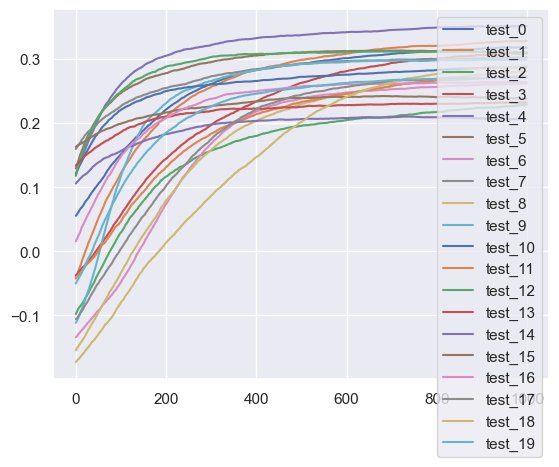

In [761]:
for i in range(len(test_acc_list)):
    plt.plot(test_acc_list[i,:],label = 'test_' + str(i))
plt.legend()
plt.show()

# Prediction

In [762]:
dataset = Data(np.array(X_train),np.array(y_train))
trainset, testset = random_split(dataset,[0.99,0.01])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=len(trainset),
                                shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset),
                                shuffle=True, num_workers=0)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net =  Net(np.array(X_train).shape[1],1)
net = net.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
train_epoch = 1000
pbar = tqdm(range(train_epoch))
for epoch in pbar:  
    net.train()
    train_loss = 0.0
    correct = 0
    for i, (inputs, y_true) in enumerate(trainloader, 0):
        inputs, y_true = inputs.to(device), y_true.to(device) 
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = loss_nn(outputs, y_true, net,lamda = 0.01)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(y_true)
    
    loss_test = compute_test_acc(net, testloader, device)
    loss_train = train_loss/len(trainset)
    if(epoch%10 == 0):
        pbar.set_postfix({'train_loss': loss_train,'test_acc': loss_test})

100%|██████████| 1000/1000 [00:22<00:00, 43.55it/s, train_loss=0.468, test_acc=0.771]


In [763]:

with torch.no_grad():
    y_predict = net(torch.tensor(np.array(X_test)))
y_predict = y_predict.reshape(-1).numpy()

In [764]:
sub = pd.DataFrame()
sub['ID'] = id_test
sub['TARGET'] = y_predict
sub.to_csv("submissions/best_neural_network.csv",index=False)

In [765]:
y_best = pd.read_csv("submissions/best_models/best_mape_augmented_3.csv")
test = pd.merge(sub,y_best,on='ID')
test.corr()

,ID,TARGET_x,TARGET_y
ID,1.000000,-0.199565,0.112504
TARGET_x,-0.199565,1.000000,0.892590
TARGET_y,0.112504,0.892590,1.000000
